# Riemannian Score Fréchet Means

In [10]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts, dWs
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics import diffusion_mean as dm_bridge
from jaxgeometry.stochastics import Brownian_coords, product_sde, Brownian_sR
from jaxgeometry.stochastics.product_sde import tile
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap
import jax.random as jrandom

import scipy.io as sio

import os

from load_manifold import get_generator_dim, load_manifold

import torch
import torchvision.utils as vutils

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader, generators
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from models import models

In [11]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [12]:
s1loss_type = 'dsm'
s2loss_type = 'dsm'
s2_type = 's1s2'
s2_approx = 0
seed = 2712

t0 = 0.1
score_path = "scores"

In [13]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1T_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}T_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Score Fréchet Mean

In [14]:
figure_path = '../figures/frechet_mean/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [20]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)
test = ScoreEval.grady_log(x0,(jnp.ones(2),jnp.zeros(1)),0.01)*0.01
test /= jnp.linalg.norm(test)
print(test)
print(ScoreEval.grady_log(x0,(jnp.ones(2),jnp.zeros(1)),0.01)*0.01)

using M.Exp for Logarithm
[-0.6713503  -0.74114019]
[-0.24287849 -0.2681268 ]


In [17]:
M.grady_log_hk(x0,(jnp.ones(2),jnp.zeros(1)),0.01)[0]*0.01
test = M.grady_log_hk(x0,(jnp.ones(2),jnp.zeros(1)),0.01)[0]*0.01
print(test/jnp.linalg.norm(test))
print(test)

[-0.70710678 -0.70710678]
[-1. -1.]


### Synthetic Data

#### $\mathbb{S}^{2}$

In [9]:
M, x0, ScoreEval = load_score_model("Sphere", 2)
data_folder = '../data/'

using M.Exp for Logarithm


In [13]:
Brownian_coords(M)
dm_bridge(M)

In [14]:
data_path = f"{data_folder}Sphere2/"
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
S2_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [15]:
dm_score(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], 
                     s2_model = M.gradt_log_hk, method="Gradient")
S2mu_sm, S2T_sm, gradx_sm, _ = M.sm_dmxt(S2_obs, (S2_obs[0][0], S2_obs[1][0]), jnp.array([t0]), \
                                                       step_size=0.01, max_iter=1000)
S2T_opt = S2T_sm[-1]
S2mu_opt = (S2mu_sm[0][-1], S2mu_sm[1][-1])

In [16]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = ScoreEval.gradt_log, method="Gradient")

In [17]:
S2mu_sm, S2T_sm, gradx_sm, _ = M.sm_dmxt(S2_obs, (S2_obs[0][0], S2_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

In [18]:
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(S2_obs,
                                                                           num_steps=100,
                                                                           N=1)
            
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
S2mu_bridgex, S2mu_bridgechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)

Step 0 | T: 1.169548e+01 | T: ((Array([8.26593176e-19, 0.00000000e+00], dtype=float64), Array(0.21, dtype=float64)), Array([0.28296944, 0.41774554, 0.86337533], dtype=float64))
Step 1 | T: 1.087946e+01 | T: ((Array([-0.00977305, -0.00995027], dtype=float64), Array(0.21995415, dtype=float64)), Array([0.28296944, 0.41774554, 0.86337533], dtype=float64))
Step 2 | T: 9.555291e+00 | T: ((Array([-0.01934577, -0.01980719], dtype=float64), Array(0.22979419, dtype=float64)), Array([0.28296944, 0.41774554, 0.86337533], dtype=float64))
Step 3 | T: 8.438901e+00 | T: ((Array([-0.02867937, -0.02953499], dtype=float64), Array(0.23947415, dtype=float64)), Array([0.28296944, 0.41774554, 0.86337533], dtype=float64))
Step 4 | T: 7.496891e+00 | T: ((Array([-0.03772808, -0.0391024 ], dtype=float64), Array(0.24895878, dtype=float64)), Array([0.28296944, 0.41774554, 0.86337533], dtype=float64))
Step 5 | T: 6.702679e+00 | T: ((Array([-0.04644536, -0.04848165], dtype=float64), Array(0.25822101, dtype=float64))

Step 47 | T: 1.035364e+00 | T: ((Array([-0.00220592, -0.07912214], dtype=float64), Array(0.44966679, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 48 | T: 1.024609e+00 | T: ((Array([-0.00132499, -0.08006054], dtype=float64), Array(0.45162119, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 49 | T: 1.014403e+00 | T: ((Array([-0.00046885, -0.08090953], dtype=float64), Array(0.45352949, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 50 | T: 1.004663e+00 | T: ((Array([ 0.0003576 , -0.08167409], dtype=float64), Array(0.4553942, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 51 | T: 9.958183e-01 | T: ((Array([ 0.00114986, -0.08235878], dtype=float64), Array(0.45721775, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 52 | T: 9.869748e-01 | T: ((Array([ 0.00190458, -0.08296791], dtype=float64), Array(0.45900233, dtype=floa

Step 94 | T: 7.852259e-01 | T: ((Array([ 0.00529506, -0.07967181], dtype=float64), Array(0.51449378, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 95 | T: 7.825740e-01 | T: ((Array([ 0.00520207, -0.07943546], dtype=float64), Array(0.51554062, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 96 | T: 7.798141e-01 | T: ((Array([ 0.00511701, -0.07920258], dtype=float64), Array(0.51657887, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 97 | T: 7.773715e-01 | T: ((Array([ 0.0050406 , -0.07897374], dtype=float64), Array(0.51760873, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 98 | T: 7.745243e-01 | T: ((Array([ 0.00497103, -0.07874884], dtype=float64), Array(0.51863032, dtype=float64)), Array([0.02843852, 0.13708432, 0.98795398], dtype=float64))
Step 99 | T: 7.717847e-01 | T: ((Array([ 0.00490867, -0.07852813], dtype=float64), Array(0.51964367, dtype=flo

#### Landmarks 2x2

In [25]:
M, x0, ScoreEval = load_score_model("Landmarks", 2)
data_folder = '../data/'
t0 = 0.2

using M.Exp for Logarithm


In [26]:
data_path = f"{data_folder}Landmarks2/"
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
landmarks_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [27]:
landmarksmu_opt = x0

In [28]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = ScoreEval.gradt_log, method="Gradient")

In [29]:
landmarksmu_sm, landmarksT_sm, gradx_sm, _ = M.sm_dmxt(landmarks_obs, (landmarks_obs[0][0], landmarks_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

#### Plotting

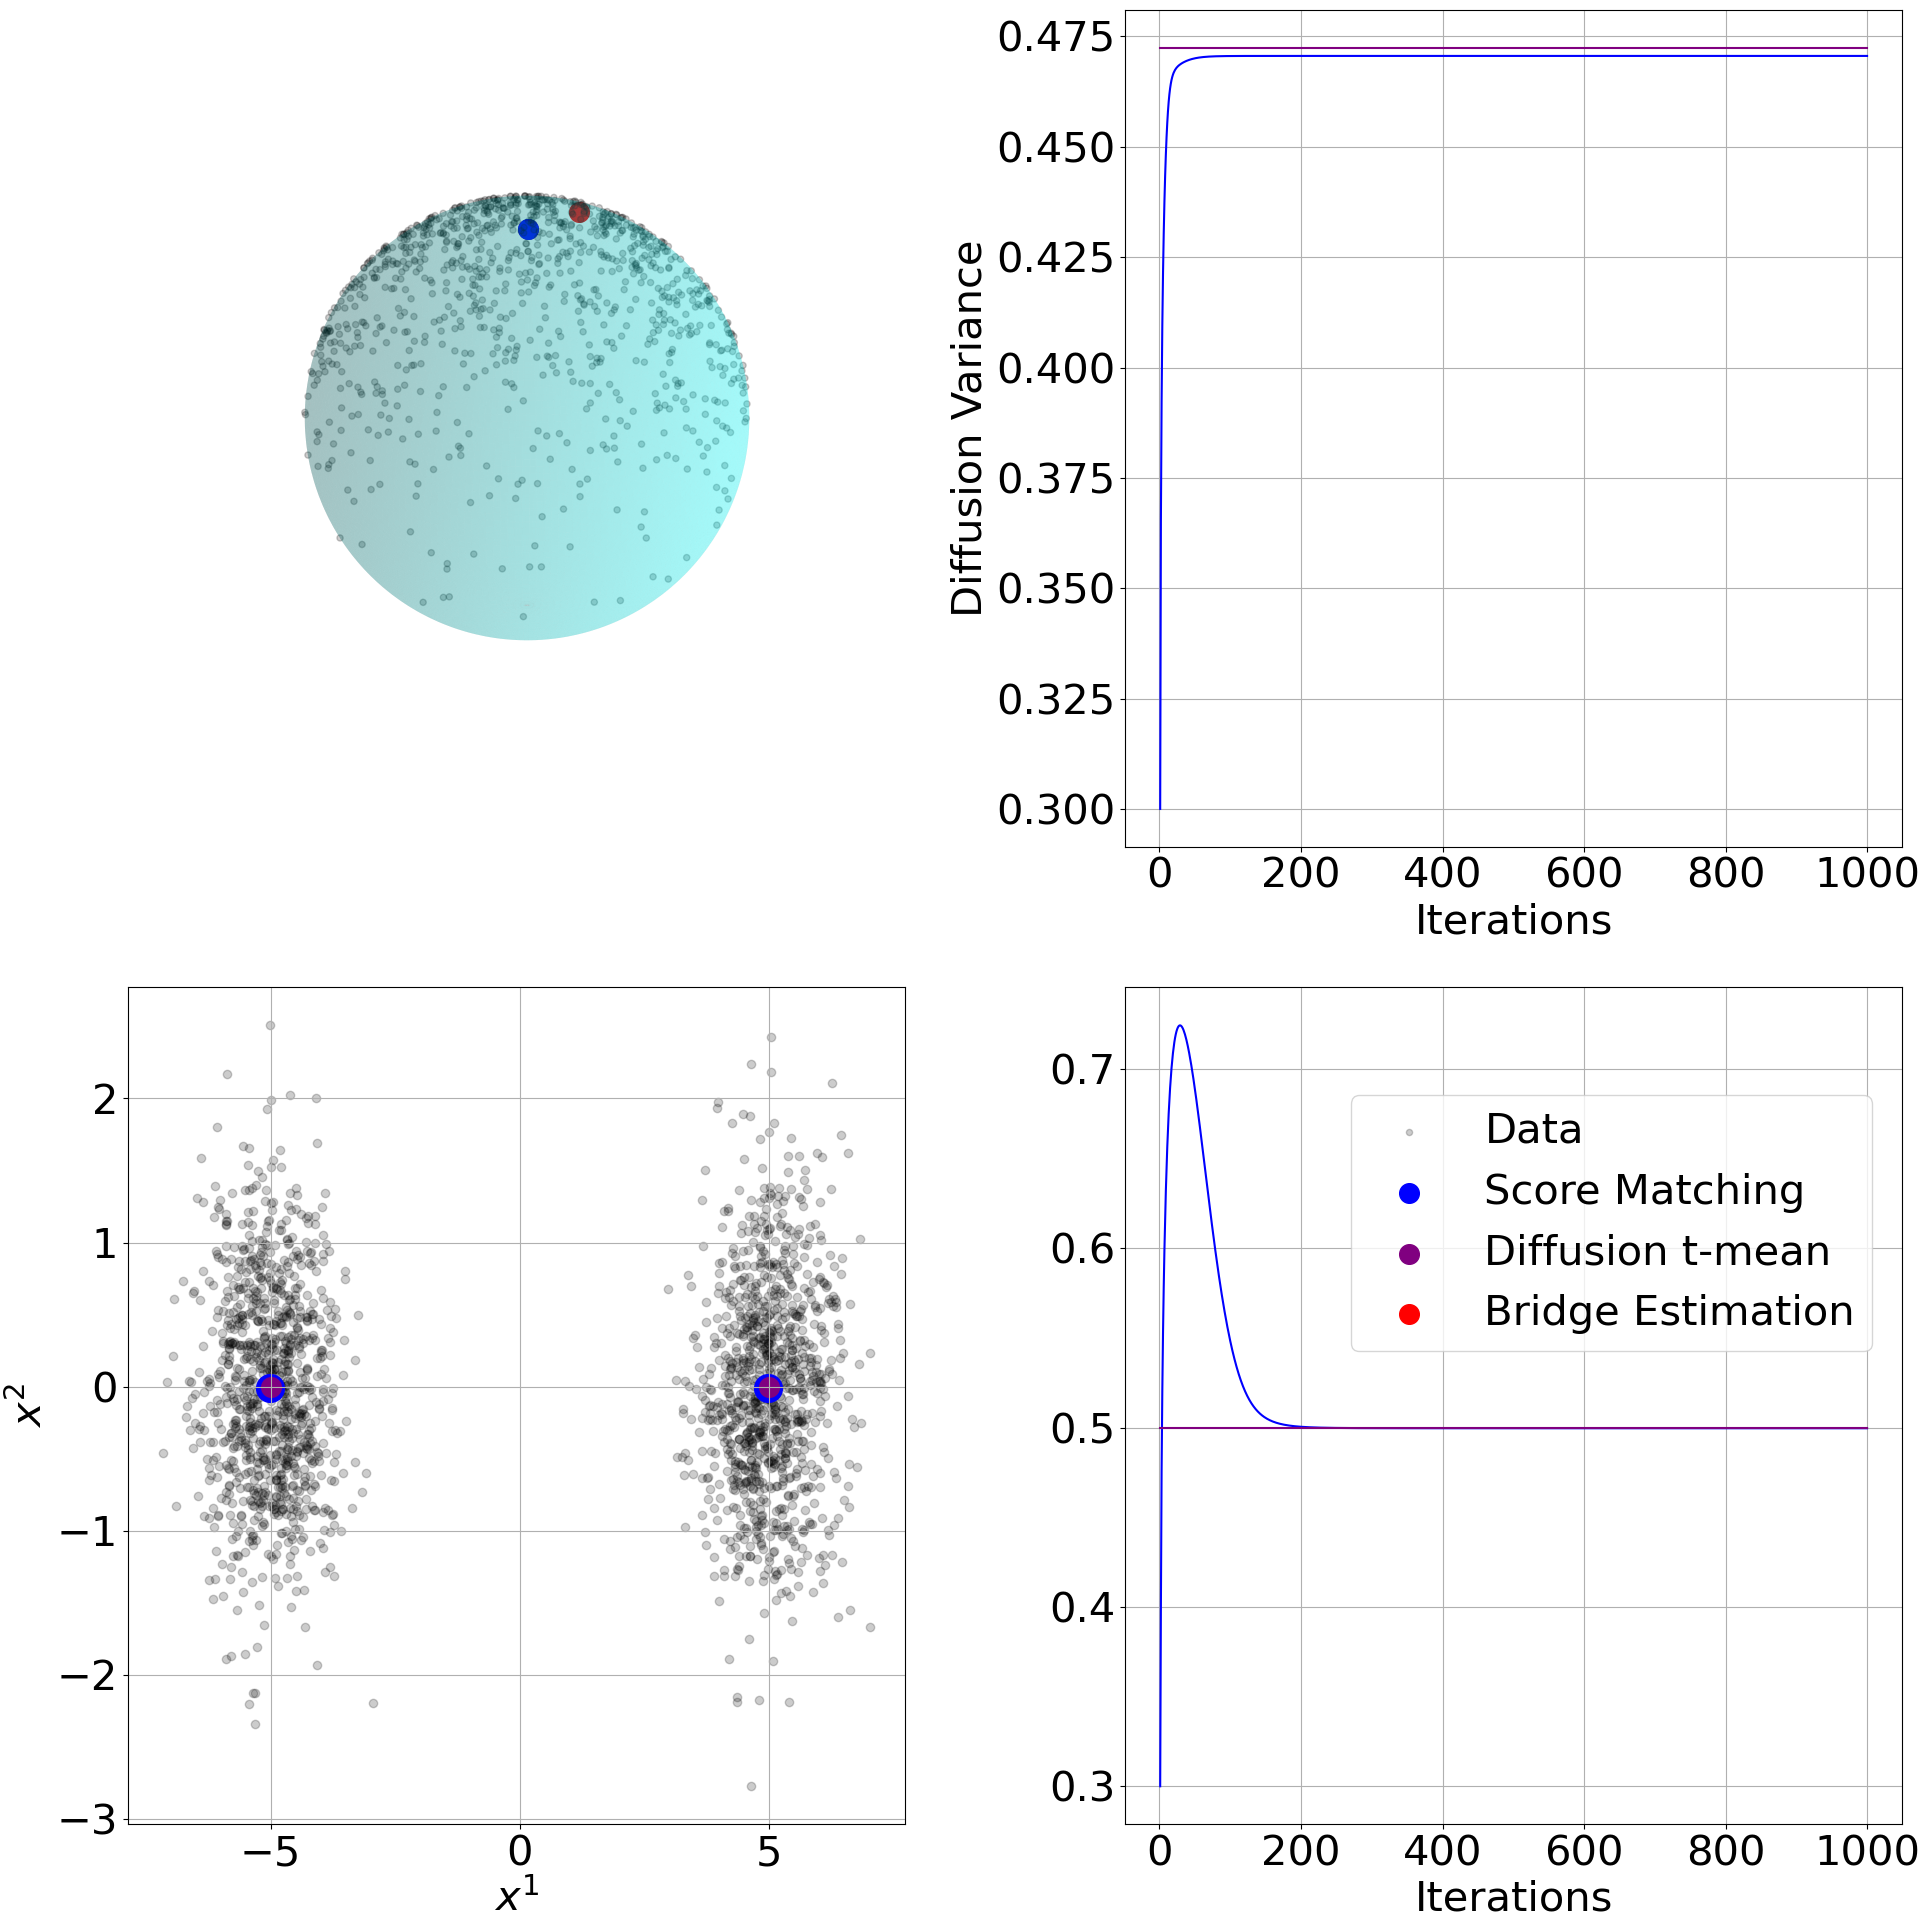

In [30]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(20,20))
#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(S2_obs[1][:,0], S2_obs[1][:,1], S2_obs[1][:,2], color='black', alpha=0.2, label='Data')
ax.scatter(S2mu_sm[1][-1,0], S2mu_sm[1][-1,1], S2mu_sm[1][-1,2], color='blue', label='Score Matching', alpha=1.0, s=200)
ax.scatter(S2mu_opt[1][0], S2mu_opt[1][1], S2mu_opt[1][2], color='purple', label='Diffusion t-mean', s=200)
ax.scatter(S2mu_bridgechart[-1,0], S2mu_bridgechart[1,1], S2mu_bridgechart[2,2], color='red', label='Bridge Estimation', s=200)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(222)
ax.plot(jnp.arange(1,len(S2T_sm)+1, 1), S2T_sm, color='blue')
ax.plot(jnp.arange(1,len(S2T_sm)+1, 1), S2T_opt*jnp.ones(len(S2T_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

#Landmarks
ax = fig.add_subplot(223)
obs = landmarks_obs[0].reshape(-1,2,2)
for i in range(len(obs)):
    plt.scatter(obs[i][0,0], obs[i][0,1], color='black', alpha=0.2)
    plt.scatter(obs[i][1,0], obs[i][1,1], color='black', alpha=0.2)
plt.scatter(landmarksmu_sm[0][-1].reshape(2,2)[0,0], landmarksmu_sm[0][-1].reshape(2,2)[0,1], color='blue', s=400)
plt.scatter(landmarksmu_sm[0][-1].reshape(2,2)[1,0], landmarksmu_sm[0][-1].reshape(2,2)[1,1], color='blue', s=400)
plt.scatter(x0[0].reshape(2,2)[0,0], x0[0].reshape(2,2)[0,1], color='purple', s=200)
plt.scatter(x0[0].reshape(2,2)[1,0], x0[0].reshape(2,2)[1,1], color='purple', s=200)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(224)
ax.plot(jnp.arange(1,len(landmarksT_sm)+1, 1), landmarksT_sm, color='blue')
ax.plot(jnp.arange(1,len(landmarksT_sm)+1, 1), 0.5*jnp.ones(len(landmarksT_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.7,0.3), ncol=1)

plt.show()

fig.savefig(f'{figure_path}score_synthetic_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

### Real-World Data

#### GP - MNIST

In [31]:
M, x0, ScoreEval = load_score_model("gp_mnist", 2)

using M.Exp for Logarithm


In [32]:
from gp.gp import RM_EG
default_omega = 500.
        
def k_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,beta,omega)

def DDk_fun(x,y, beta=1.0, omega=default_omega):

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,beta,omega)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

rot = jnp.load('Data/MNIST/rot.npy')
num_rotate = len(rot)

theta = jnp.linspace(0,2*jnp.pi,num_rotate)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

sigman = 0.0
X_training = jnp.vstack((x1,x2))
y_training = rot.reshape(num_rotate, -1).T
RMEG = RM_EG(X_training, y_training, sigman=sigman, k_fun=k_fun, 
             Dk_fun = Dk_fun, DDk_fun = DDk_fun, delta_stable=1e-10)

g = lambda x: RMEG.G(x[0])

In [33]:
gpmnist_obs = (X_training[:,:len(rot)//2].T, jnp.zeros(len(rot)//2).reshape(-1,1))

In [34]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [35]:
gpmnistmu_sm, gpmnistT_sm, *_ = M.sm_dmxt(gpmnist_obs, (gpmnist_obs[0][0], gpmnist_obs[1][0]), jnp.array([t0]), \
                                                   step_size=0.01, max_iter=1000)

In [39]:
gp_mu = RMEG.post_mom(gpmnistmu_sm[0][-1])[0]
data_post = vmap(lambda x: RMEG.post_mom(x)[0])(gpmnist_obs[0])
mnist_data = torch.Tensor(np.array(data_post.reshape(-1,1,28,28)))

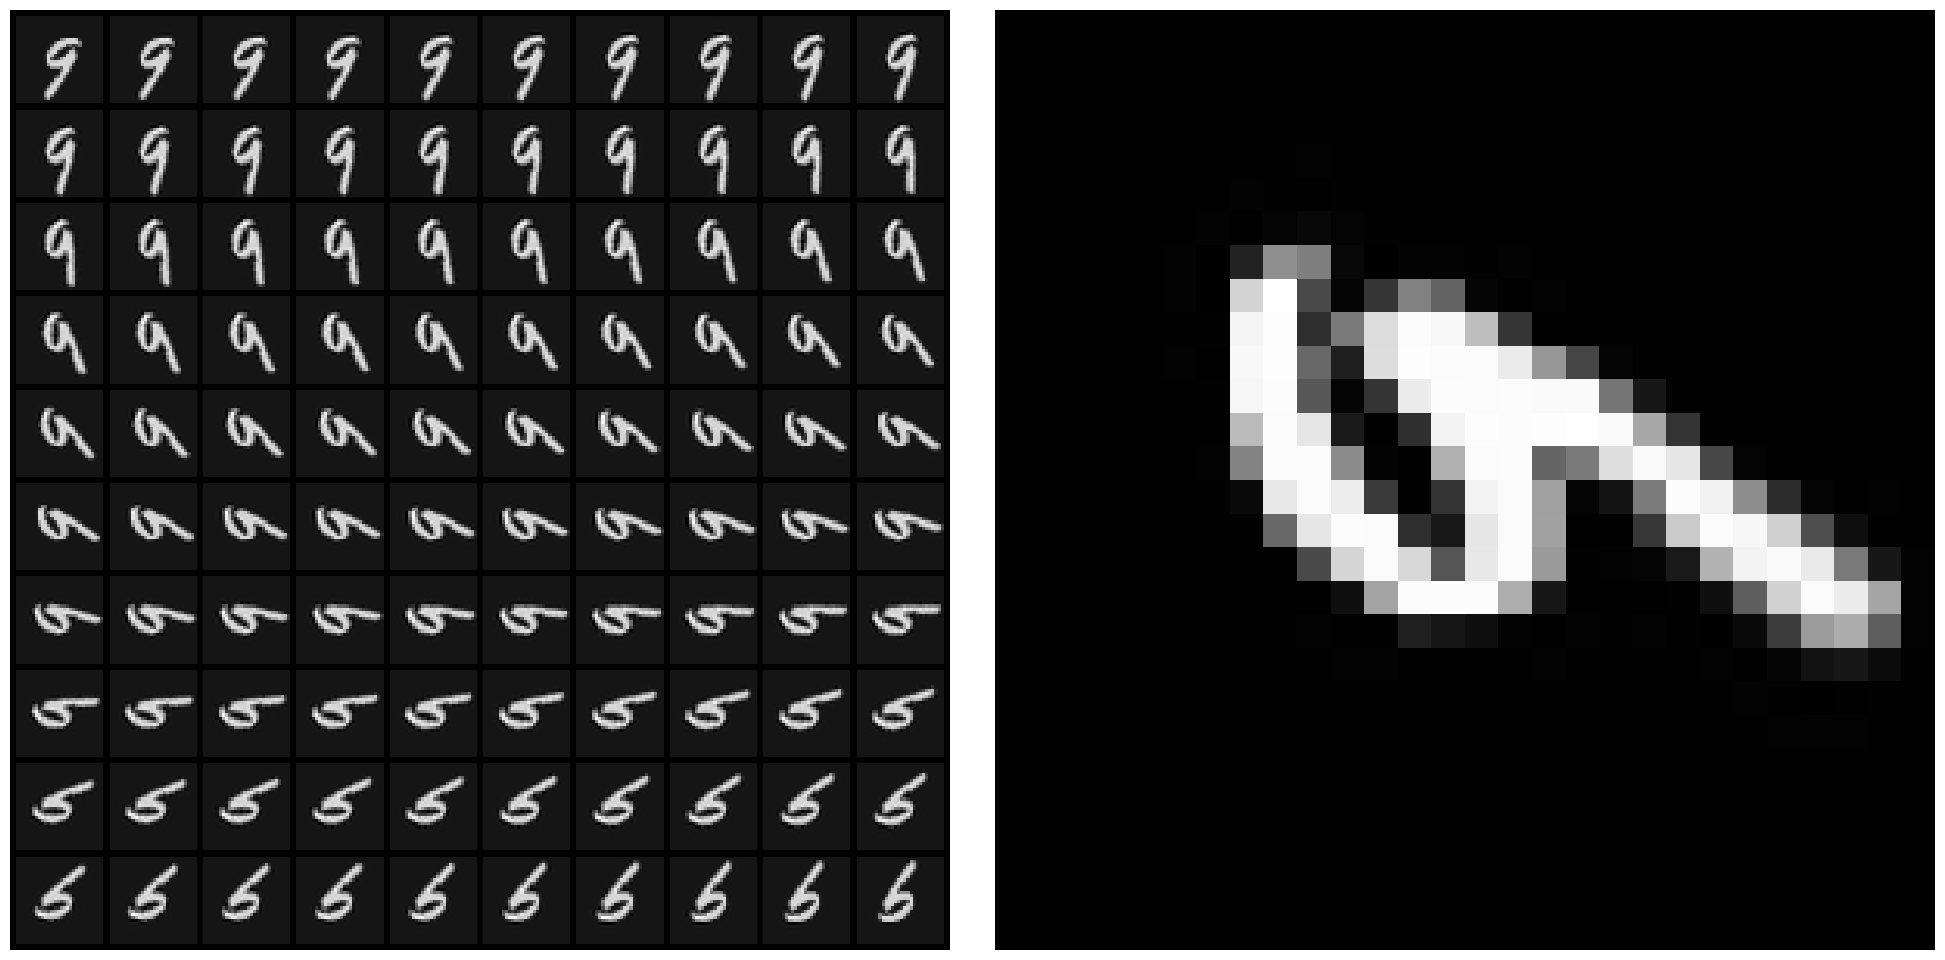

In [40]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()
ax = fig.add_subplot(122)
ax.imshow(gp_mu.reshape(28,28), cmap='gray')
ax.set_axis_off()
fig.tight_layout()

#### Landmarks - Cardiac Data

In [49]:
N_sample = 30
M, x0, ScoreEval = load_score_model("Landmarks", N_sample)

using M.Exp for Logarithm


In [50]:
import os
import imageio
path = '../../../Data/landmarks/cardiac/'
cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))

import scipy as sp

def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1

    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0

    return image[m].reshape((y2+1-y1, x2+1-x1))

cardiac_image = crop(cardiac_image, 90, 175, 80, 160)

/tmp/ipykernel_53907/217648315.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cardiac_image= imageio.imread(os.path.join(path,'c4480h_s1.png'))


In [51]:
import glob

#%% Hyper-parameters
n = 66
d = 2

files = glob.glob("../../../Data/landmarks/cardiac/*.asf")
K = len(files)

qs = jnp.zeros((K,n,d))
for j in range(K):
    try:
        in_file = open(files[j], 'r')

        NN = -1
        for line in in_file.readlines():
            if len(line) > 1 and line[0] != '#':
                splits = line.split()
                if NN < 0 and len(splits) == 1:
                    NN = int(splits[0])
                    q = jnp.zeros((n,d))
                    i = 0
                if len(splits) >= 7:
                    q = q.at[i,0].set(float(splits[2]))
                    q = q.at[i,1].set(float(splits[3]))
                    i = i + 1 
    finally:
        in_file.close()
    qs = qs.at[j].set(q-jnp.tile(jnp.mean(q,axis=0),((q.shape[0],1))))


idx = jnp.round(np.linspace(0, qs.shape[1] - 1, N_sample)).astype(int)
landmark_data = qs[:,idx].reshape(qs.shape[0],-1)*1000

In [52]:
cardiac_obs = (landmark_data, jnp.zeros(len(landmark_data)))

In [53]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [54]:
cardiacmu_sm, cardiacT_sm, *_ = M.sm_dmxt(cardiac_obs, (cardiac_obs[0][0], cardiac_obs[1][0]), jnp.array([0.2]), \
                                                   step_size=0.01, max_iter=1000)

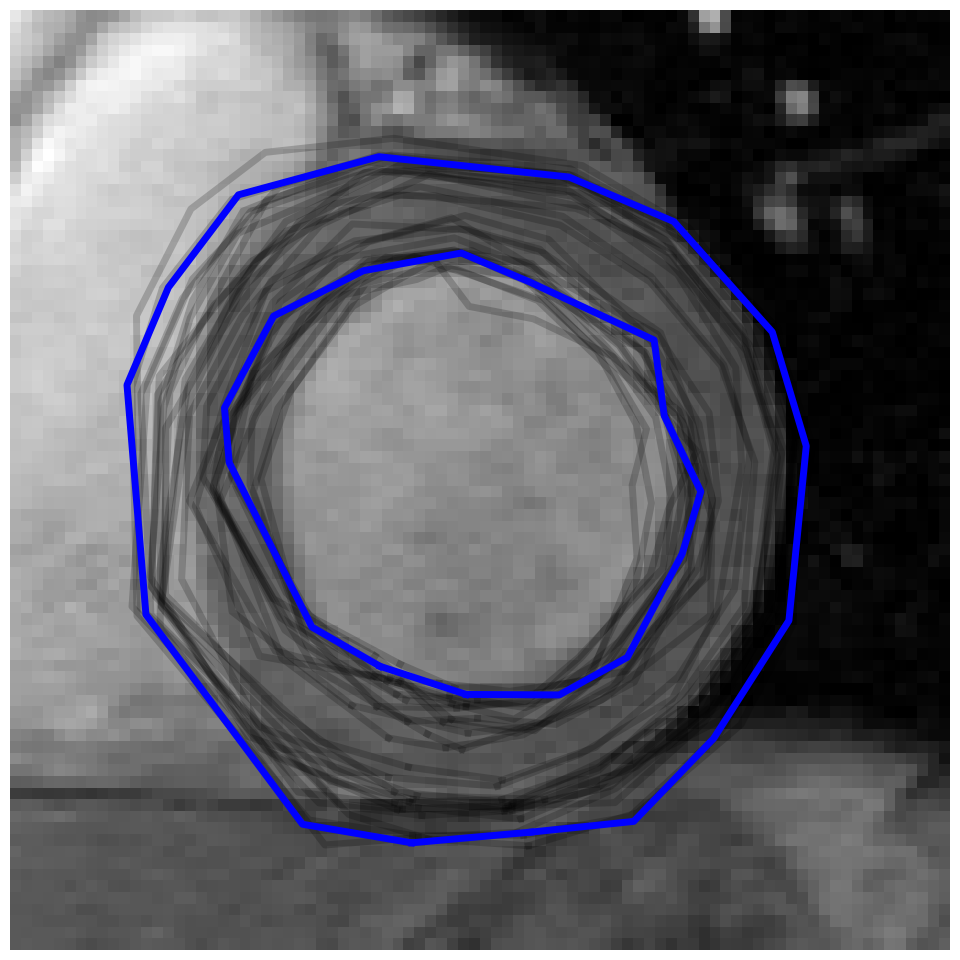

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(cardiac_image, interpolation='none', extent=[-150.0,150.0, -150.0, 150.0], cmap='gray')
ax.set_aspect(1)
N_half = N_sample // 2
mu = cardiacmu_sm[0][-1].reshape(-1,2)/1
for wing in cardiac_obs[0]:
    wing = wing.reshape(-1,2)/1
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2,linewidth=5)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2, linewidth=5)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue', linewidth=5)
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue', linewidth=5)
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

#### Landmarks - Butterfly Data

In [56]:
N_sample = 30
M, x0, ScoreEval = load_score_model("Landmarks", N_sample)

using M.Exp for Logarithm


In [59]:
data = pd.read_csv('../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [60]:
with open('../../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [61]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)
    idx = jnp.round(np.linspace(0, len(data1) - 1, N_sample)).astype(int)
    landmark_data.append(jnp.vstack((data1[idx], data2[idx])).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [62]:
butterfly_obs = (jnp.array(landmark_data, dtype=jnp.float64), jnp.zeros(len(landmark_data)))

In [63]:
dm_score(M, s1_model=ScoreEval.grady_log, s2_model = lambda x,y,t: ScoreEval.gradt_log(x,y,t), method="JAX")

In [64]:
butterflymu_sm, butterflyT_sm, *_ = M.sm_dmxt(butterfly_obs, (butterfly_obs[0][0], butterfly_obs[1][0]), jnp.array([0.2]), \
                                                   step_size=0.01, max_iter=1000)

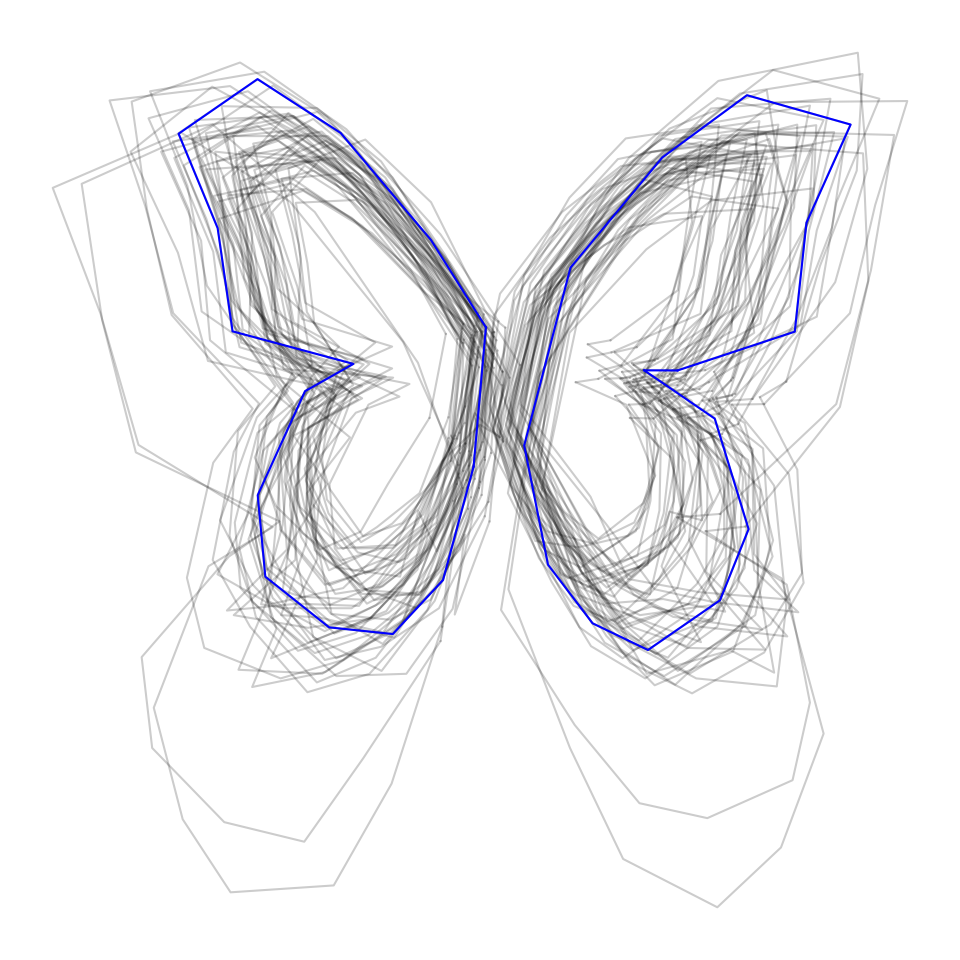

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
N_half = N_sample // 2
mu = butterflymu_sm[0][-1].reshape(-1,2)
for wing in butterfly_obs[0]:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

### Plotting

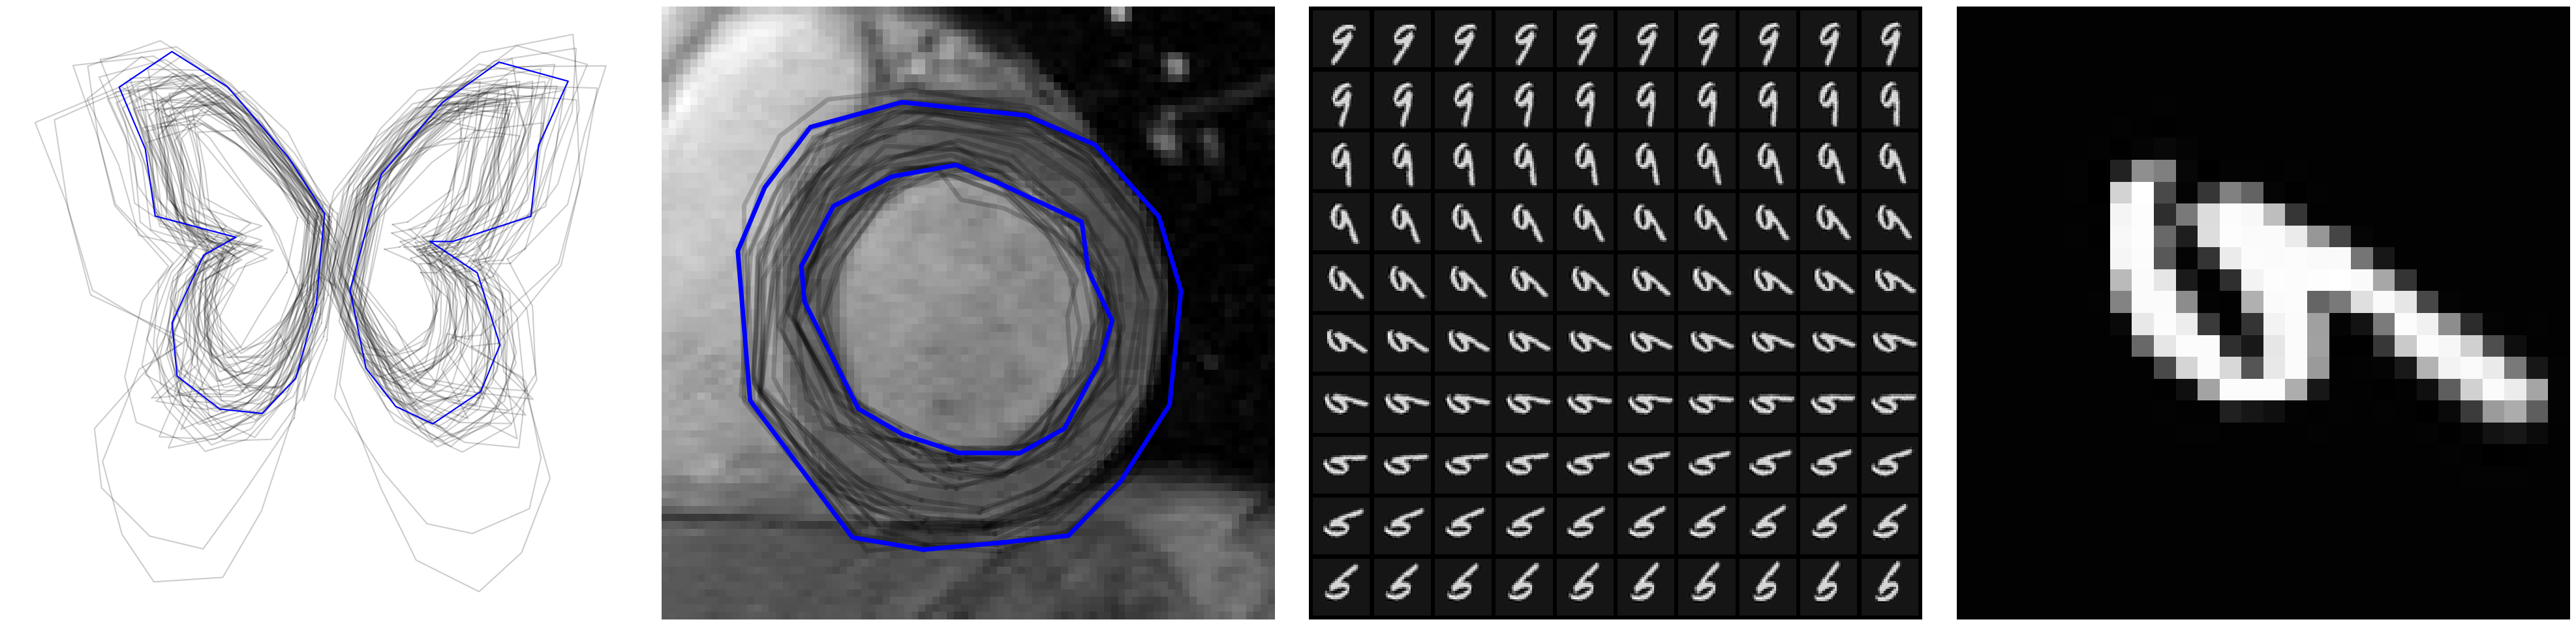

In [68]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
N_half = N_sample // 2
mu = butterflymu_sm[0][-1].reshape(-1,2)
for wing in butterfly_obs[0]:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

ax = fig.add_subplot(142)
ax.imshow(cardiac_image, interpolation='none', extent=[-150.0,150.0, -150.0, 150.0], cmap='gray')
ax.set_aspect(1)
N_half = N_sample // 2
mu = cardiacmu_sm[0][-1].reshape(-1,2)/1
for wing in cardiac_obs[0]:
    wing = wing.reshape(-1,2)/1
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2,linewidth=5)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2, linewidth=5)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2, linewidth=5)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue', linewidth=5)
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue', linewidth=5)
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue', linewidth=5)
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

ax = fig.add_subplot(143)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()
ax = fig.add_subplot(144)
ax.imshow(gp_mu.reshape(28,28), cmap='gray')
ax.set_axis_off()

fig.tight_layout()

fig.savefig(f'{figure_path}score_real_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


## Distance and Logaritmic Estimation

### $\mathcal{GP}$ for MNIST

In [6]:
M, x0, ScoreEval = load_score_model("gp_mnist", 2)

using M.Exp for Logarithm


In [7]:
from gp.gp import RM_EG
default_omega = 500.
        
def k_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,beta,omega)

def DDk_fun(x,y, beta=1.0, omega=default_omega):

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,beta,omega)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

rot = jnp.load('Data/MNIST/rot.npy')
num_rotate = len(rot)

theta = jnp.linspace(0,2*jnp.pi,num_rotate)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

sigman = 0.0
X_training = jnp.vstack((x1,x2))
y_training = rot.reshape(num_rotate, -1).T
RMEG = RM_EG(X_training, y_training, sigman=sigman, k_fun=k_fun, 
             Dk_fun = Dk_fun, DDk_fun = DDk_fun, delta_stable=1e-10)

g = lambda x: RMEG.G(x[0])

In [8]:
gpmnist_obs = (X_training[:,:len(rot)//2].T, jnp.zeros(len(rot)//2).reshape(-1,1))

In [9]:
xT = (jnp.array([0.0,1.0]), jnp.zeros(1))

In [36]:
val = RMEG.min_energy(x0[0],xT[0],40,1)

         Current function value: 26.000619
         Iterations: 100
         Function evaluations: 8690
         Gradient evaluations: 110


/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [14]:
RMEG.curve_length(x0[0], xT[0], val, 1, 40)

NameError: name 'val' is not defined

In [16]:
val = x0[0]+(xT[0]-x0[0])*jnp.linspace(0,1,100)[1:].reshape(-1,1)
RMEG.curve_length(x0[0], xT[0], val, 1, 100)

Array(431.56003987, dtype=float64)

In [27]:
theta = jnp.linspace(0,jnp.pi/2,10000)[1:]
val = jnp.stack((jnp.cos(theta), jnp.sin(theta))).T
RMEG.curve_length(x0[0], xT[0], val, 1, 10000)

Array(7.4368645, dtype=float64)

In [28]:
xT[0]

Array([0., 1.], dtype=float64)

In [29]:
RMEG.G(x0[0])

Array([[ 9.99001107e+04, -8.72510813e-07],
       [-8.72509859e-07,  5.44671149e+01]], dtype=float64)

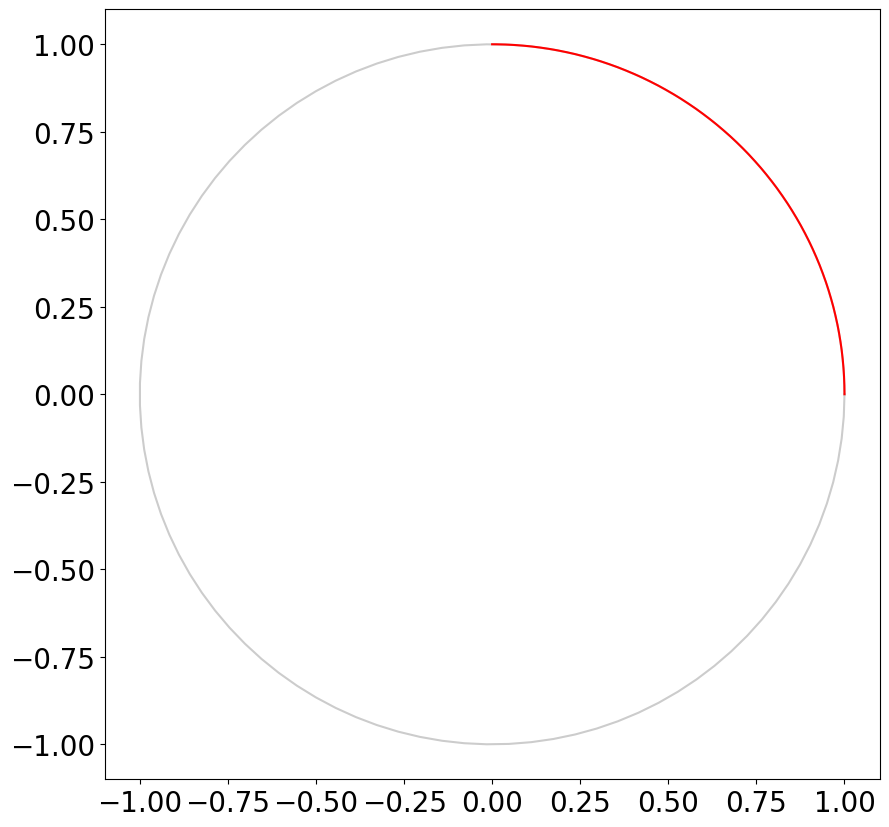

In [30]:
theta = jnp.linspace(0,2*jnp.pi,100)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x1,x2, color='black', alpha=0.2)
ax.plot(val.reshape(-1,2)[:,0], val.reshape(-1,2)[:,1], color='red', alpha=1.0)

In [31]:
2*jnp.sqrt(ScoreEval.gradt_log(x0,xT,t0))*t0

Array(1.05284816, dtype=float64)

In [32]:
ScoreEval.grady_log(x0,xT,t0)*t0

Array([ 0.76818894, -0.49103892], dtype=float64)

In [38]:
(val[0]-x0[0])/40

Array([-7.39341871e-05,  2.49260658e-02], dtype=float64)

In [7]:
from gp.gp import RM_EG
default_omega = 500.
        
def k_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, beta=1.0, omega=default_omega):

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,beta,omega)

def DDk_fun(x,y, beta=1.0, omega=default_omega):

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,beta,omega)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

rot = jnp.load('Data/MNIST/rot.npy')
num_rotate = len(rot)

theta = jnp.linspace(0,2*jnp.pi,num_rotate)
x1 = jnp.cos(theta)
x2 = jnp.sin(theta)

sigman = 0.0
X_training = jnp.vstack((x1,x2))
y_training = rot.reshape(num_rotate, -1).T
RMEG = RM_EG(X_training, y_training, sigman=sigman, k_fun=k_fun, 
             Dk_fun = Dk_fun, DDk_fun = DDk_fun, delta_stable=1e-10)

g = lambda x: RMEG.G(x[0])

In [9]:
gpmnist_obs = (X_training[:,:len(rot)//2].T, jnp.zeros(len(rot)//2).reshape(-1,1))

In [16]:
RMEG.geo_bvp(x0[0], xT[0])

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.919740
         Iterations: 12
         Function evaluations: 97
         Gradient evaluations: 84


(Array([[ 1.        ,  0.        ],
        [ 0.99556446, -0.00149809],
        [ 0.9911267 ,  0.0213762 ],
        [ 0.9838443 ,  0.00317467],
        [ 0.9731994 ,  0.00773839],
        [ 0.96299474,  0.00886095],
        [ 0.9535869 ,  0.00957169],
        [ 0.94456024,  0.01013963],
        [ 0.9354475 ,  0.01063574],
        [ 0.92593428,  0.0110879 ],
        [ 0.91588698,  0.01151108],
        [ 0.90532836,  0.01191546],
        [ 0.89438221,  0.01230864],
        [ 0.88319913,  0.01269597],
        [ 0.87189825,  0.01308066],
        [ 0.86054913,  0.01346433],
        [ 0.84918349,  0.01384768],
        [ 0.83781306,  0.01423092],
        [ 0.82644143,  0.01461415],
        [ 0.81506956,  0.01499736],
        [ 0.80369763,  0.01538058],
        [ 0.7923257 ,  0.0157638 ],
        [ 0.78095377,  0.01614702],
        [ 0.76958184,  0.01653023],
        [ 0.75820991,  0.01691345],
        [ 0.74683798,  0.01729667],
        [ 0.73546604,  0.01767989],
        [ 0.72409411,  0.018

In [32]:
M.dist(x0,xT)

Array(316.08870701, dtype=float64)

In [33]:
v = M.Log(x0,xT)

In [34]:
v

(array([-0.71903332,  1.31436883]), 0.4922007016558022)

In [22]:
test = M.geodesic(x0, v[0], jnp.linspace(0,1,100))

In [31]:
test[1][:,0]

Array([[ 1.00000000e+00,  0.00000000e+00],
       [ 9.92737037e-01,  1.32764529e-02],
       [ 9.77858621e-01,  4.30961387e-02],
       [ 9.50682288e-01, -9.08546948e-02],
       [ 6.21923286e-01,  2.11214268e-01],
       [-1.22624770e+00, -2.37262592e+00],
       [-3.44405288e+00, -5.47323414e+00],
       [-6.03149226e+00, -9.09061040e+00],
       [-8.98856584e+00, -1.32247547e+01],
       [-1.23152736e+01, -1.78756670e+01],
       [-1.60116156e+01, -2.30433474e+01],
       [-2.00775917e+01, -2.87277958e+01],
       [-2.45132021e+01, -3.49290123e+01],
       [-2.93184467e+01, -4.16469967e+01],
       [-3.44933254e+01, -4.88817493e+01],
       [-4.00378384e+01, -5.66332698e+01],
       [-4.59519855e+01, -6.49015584e+01],
       [-5.22357669e+01, -7.36866150e+01],
       [-5.88891824e+01, -8.29884397e+01],
       [-6.59122322e+01, -9.28070324e+01],
       [-7.33049161e+01, -1.03142393e+02],
       [-8.10672343e+01, -1.13994522e+02],
       [-8.91991866e+01, -1.25363419e+02],
       [-9.